<a href="https://colab.research.google.com/github/andreabenevenut/LLM_workshop/blob/main/notebooks/3_Building_a_Virtual_Assistant_with_Retrieval_Augmented_Generation_(RAG)_via_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RETRIEVAL-AUGMENTED GENERATION (RAG)
LLMs can reason about wide-ranging topics, but their knowledge is limited to the public data up to a specific point in time that they were trained on. If you want to build AI applications that can reason about private data or data introduced after a model's cutoff date, you need to augment the knowledge of the model with the specific information it needs. The process of bringing the appropriate information and inserting it into the model prompt is known as Retrieval Augmented Generation (RAG).

In the following notebook, we will go through the process of creating a virtual assistant powered by LLMs. The virtual assistant will aid us in the investigation of our sources, with the possibility of having full human-like conversations.

>[RETRIEVAL-AUGMENTED GENERATION (RAG)](#scrollTo=jlxG5NBhsNvs)

>[0: SET UP](#scrollTo=8-mi3R-LuEa5)

>[1: CREATING OUR FIRST Q&A CHATBOT](#scrollTo=PVg09NifuWsr)

>>[Document Loaders](#scrollTo=fqGluj6Y17FU)

>>[Splitting into document chunks](#scrollTo=YQA8fOUMw5ap)

>>[Vector stores](#scrollTo=rbuI9v5hxEuB)

>>[Chatbot in action!](#scrollTo=URX2oDCccIwg)

>>[Prompt customization](#scrollTo=mWIj0RQLcirS)

>[2: INTRODUCING MEMORY FOR A CONVERSATIONAL CHATBOT](#scrollTo=z5zlas7UdaEY)

>[3: INTEGRATE LLMS WITH YOUTUBE VIDEOS](#scrollTo=tW-Xl8j-ybYr)

>[4: QUERYING OVER DATAROOTS WEBSITE](#scrollTo=rm_ZmLSXse_E)



# 0: SET UP

In [ ]:
!git clone https://github.com/datarootsio/LLMs_workshop.git

In [ ]:
!pip install -r "/content/LLMs_workshop/requirements.txt"

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = ""

In [ ]:
MODEL_NAME = "gpt-3.5-turbo-1106"

# 1: CREATING OUR FIRST Q&A CHATBOT


Suppose that you have a document with thousands of pages and wish to ask questions about its content. <br>
One solution could be to directly include the entire document in the prompt of the model. This is not feasible due to the limitations of LLMs context window. Models, like GPT-3.5, have a constrained context window, often equivalent to a few pages of a document. Therefore, we need to prepare our data before feeding it to an LLM.

In the following sections, we are going to follow a step by step workflow to preprocess our data and make it ready for LLMs powered application.

## Document Loaders

The first crucial step in our data preparation process involves converting raw data into structured documents.
That's where [Document Loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/) come in handy: they allow to load data from a source as a `Document` object which consists of two key components: __page_content__ and __metadata__.
The page_content represents the textual content extracted from the document page itself. The metadata is important in tracking the specific sources utilized by the LLM when generating answers.

There exist many different document loaders for different formats (PDF, MarkDown, TXT, Youtube videos, ...).




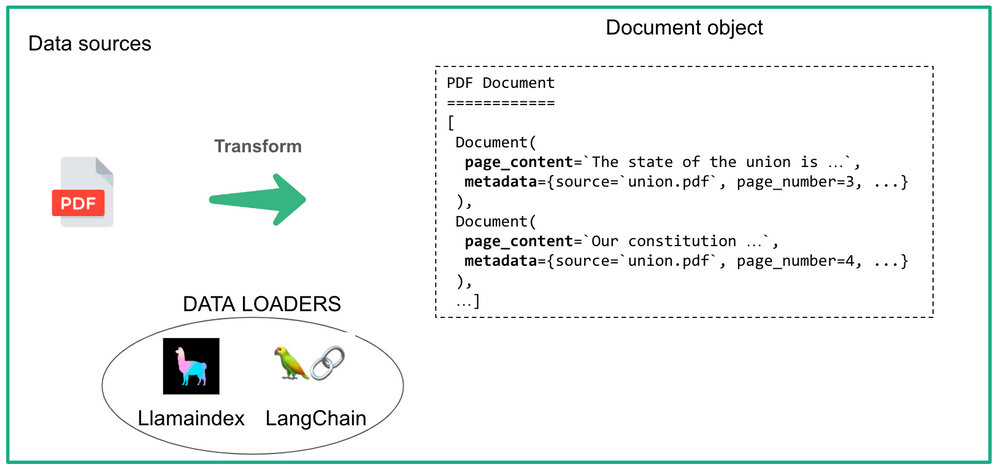



In [ ]:
from langchain.document_loaders import TextLoader

loader = TextLoader("/content/LLMs_workshop/data/state_of_the_union.txt")
state_of_the_union = loader.load()

In [ ]:
print(f"There are {len(state_of_the_union[0].page_content)} characters in the text\n")

state_of_the_union[0].page_content

In [ ]:
state_of_the_union[0].metadata

## Splitting into document chunks

Since LLMs have a limited context window, we adopt a solution by dividing our structured documents into smaller, more manageable chunks. These document chunks enable our LLM application to process information in a more efficient and effective manner.

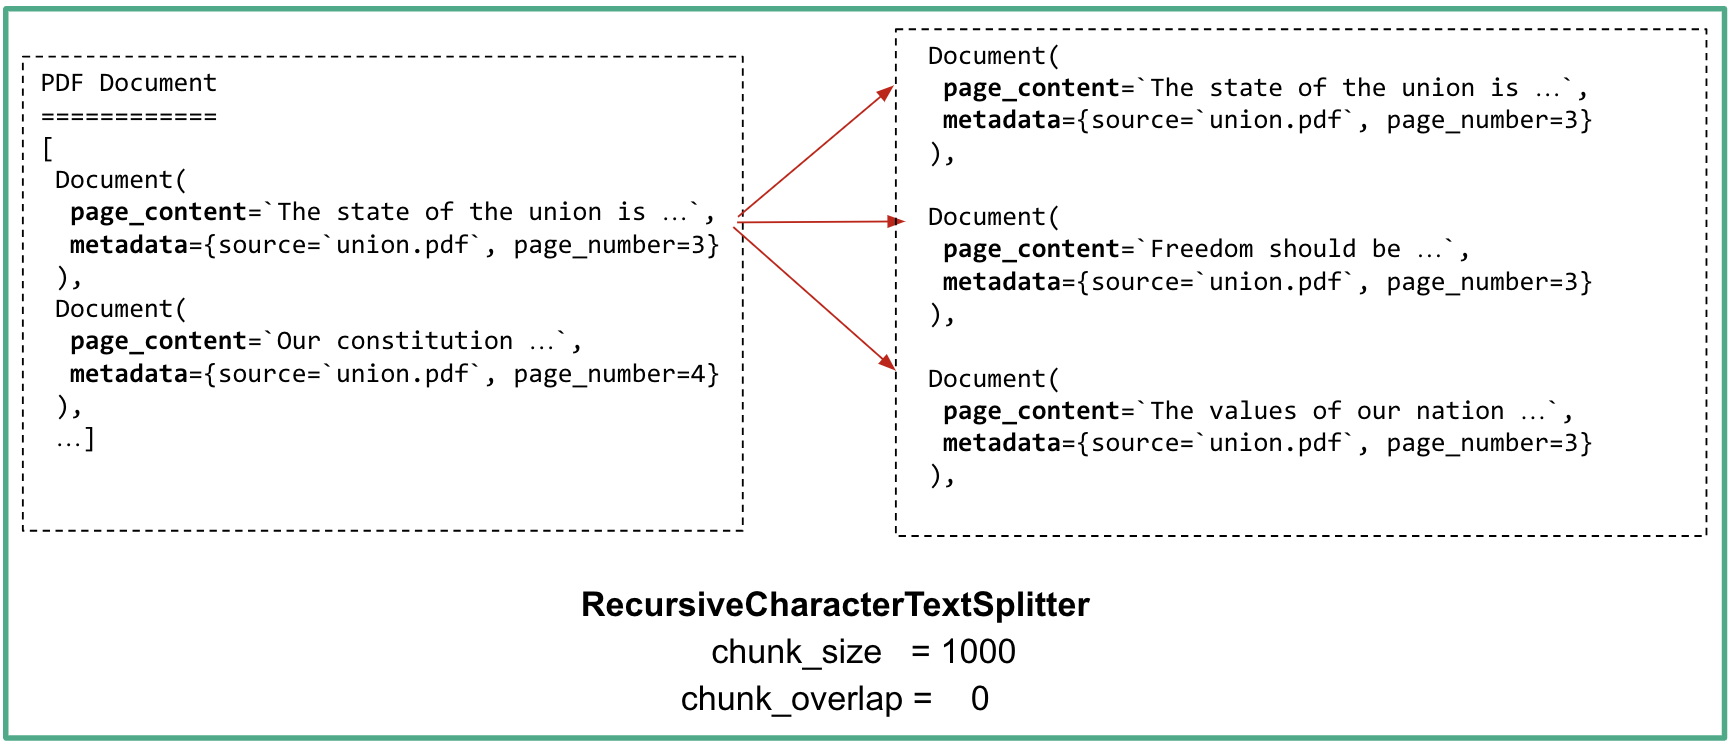

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents_chunks = text_splitter.split_documents(state_of_the_union)

for idx, doc_chunk in enumerate(documents_chunks):
    doc_chunk.metadata['source'] = f'state_of_the_union.txt, part_{idx}'


print("Number of chunks: ", len(documents_chunks))

In [ ]:
def print_chunk(document_chunk):
  content = document_chunk.page_content
  content_reformatted = content.replace('\n\n', '\n')
  print(f"'''\n{content_reformatted}\n'''")
  print(document_chunk.metadata)

print_chunk(documents_chunks[1])

## Vector stores

Now that we have our document split into smaller pieces, we need to find a way to store the information efficiently.
The idea is that, when we ask a question, we would like to retrieve the most relevant parts of the document that could be useful to answer the question.<br>
That is where vector stores come in handy.

A `vector store` refers to a data structure or database that stores pre-computed vector representations (embeddings) of documents or sources. The vector store allows efficient similarity matching between user queries and the stored sources, enabling our application to retrieve relevant documents based on their semantic similarity to the user's question.


There are many different choices. For this tutorial we will use [FAISS](https://python.langchain.com/docs/integrations/providers/facebook_faiss).



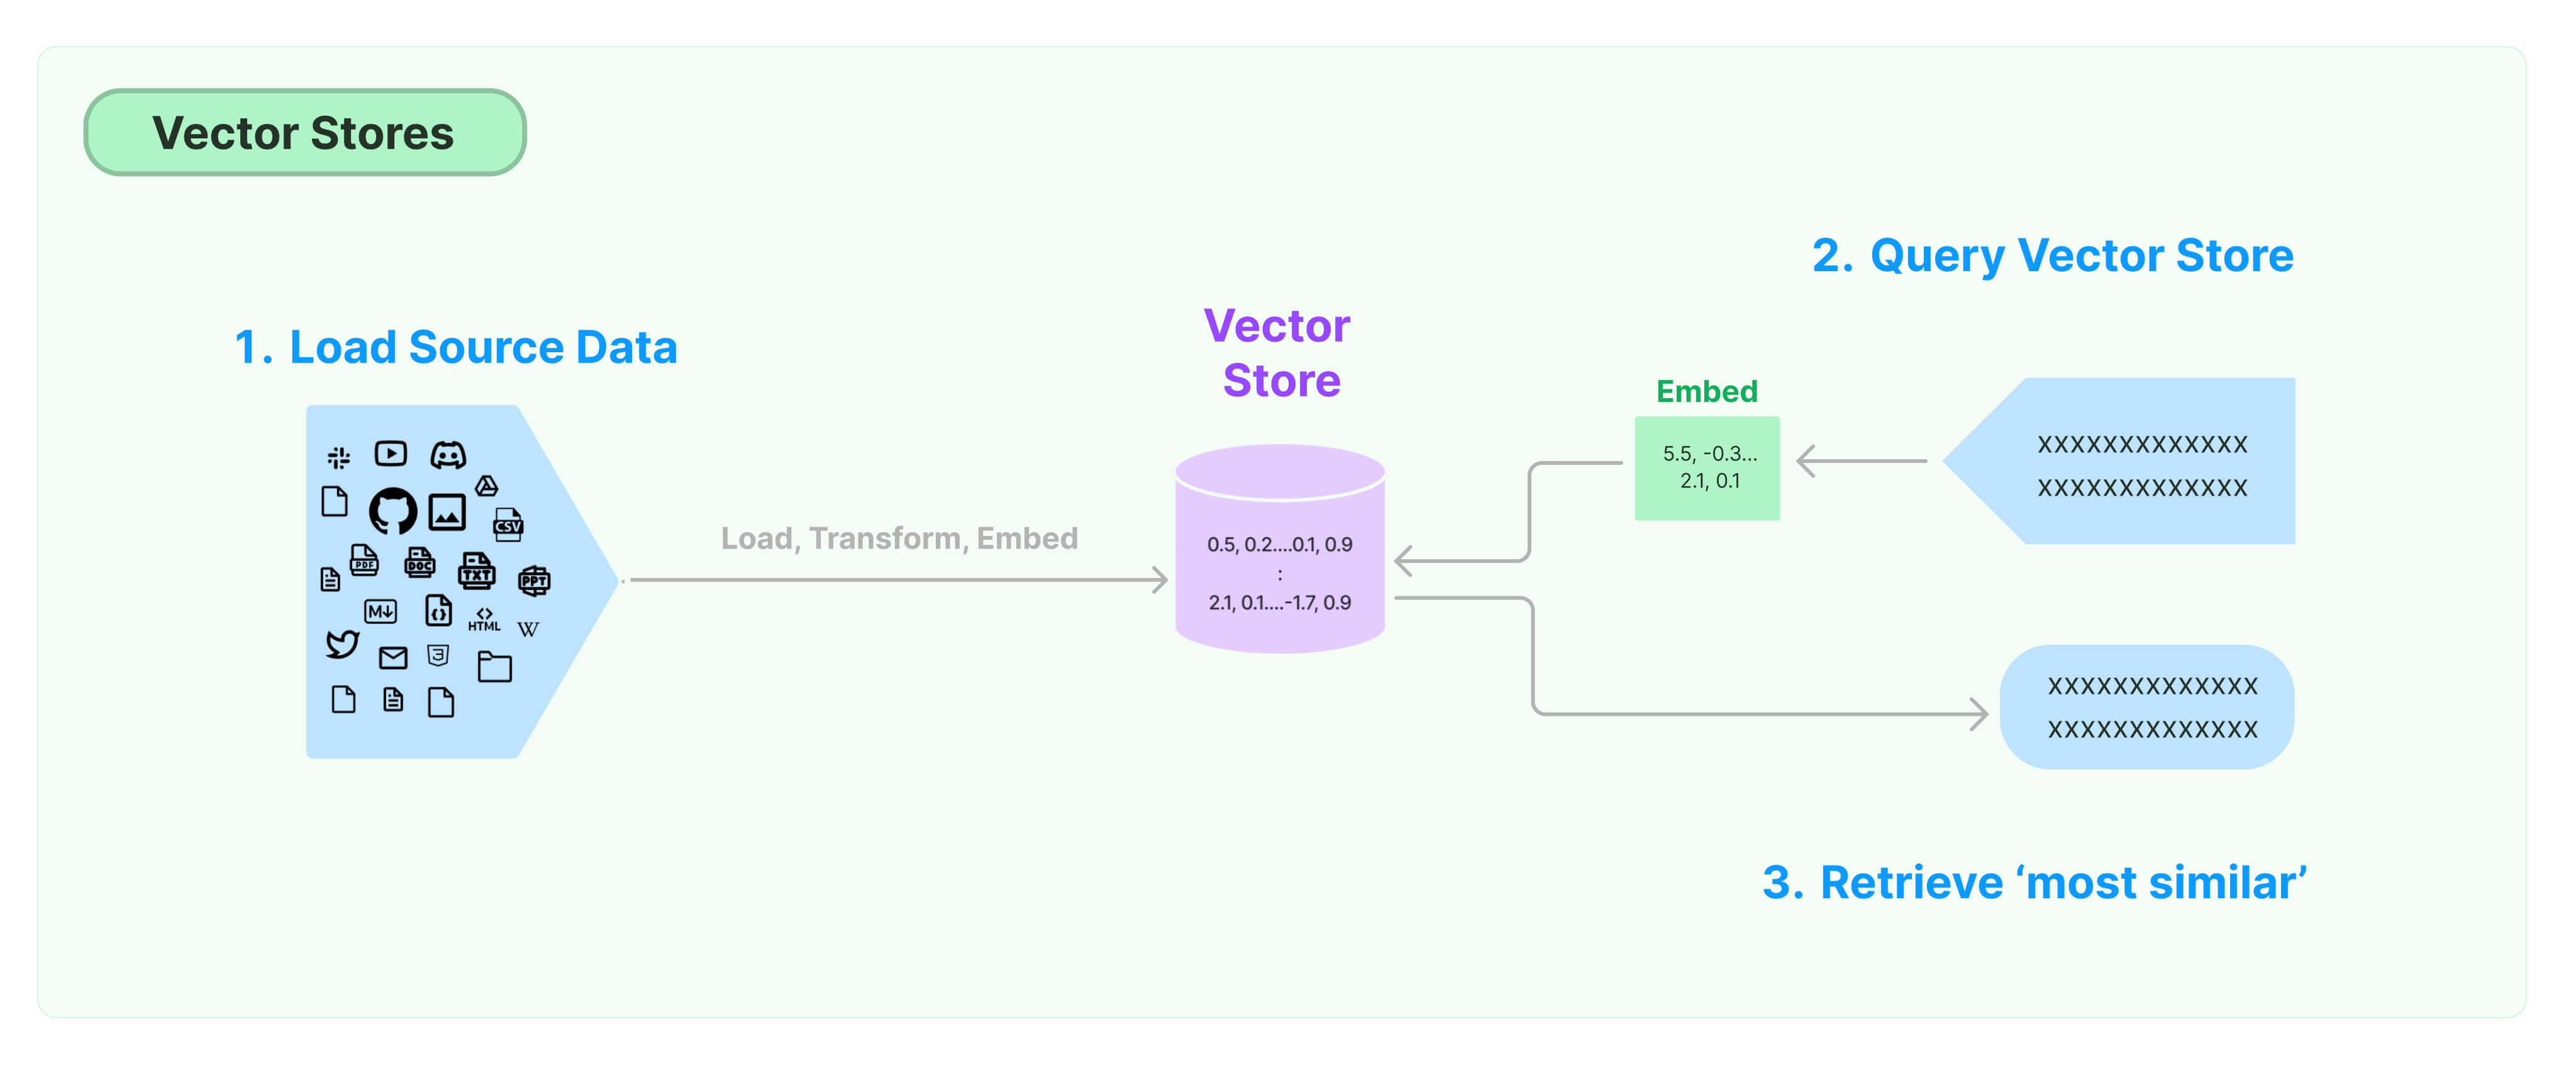

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS


vector_store = FAISS.from_documents(documents=documents_chunks,
                                    embedding=OpenAIEmbeddings())

print(f"The vectore store contains {len(vector_store.docstore._dict)} documents chunks in total.")

Now let's test our vector store against one arbitrary question. And check for the most relevant chunks. Based on a similarity score the top k most similar documents are retrieved and only those ones will be effectively insterted into the LLM prompt!

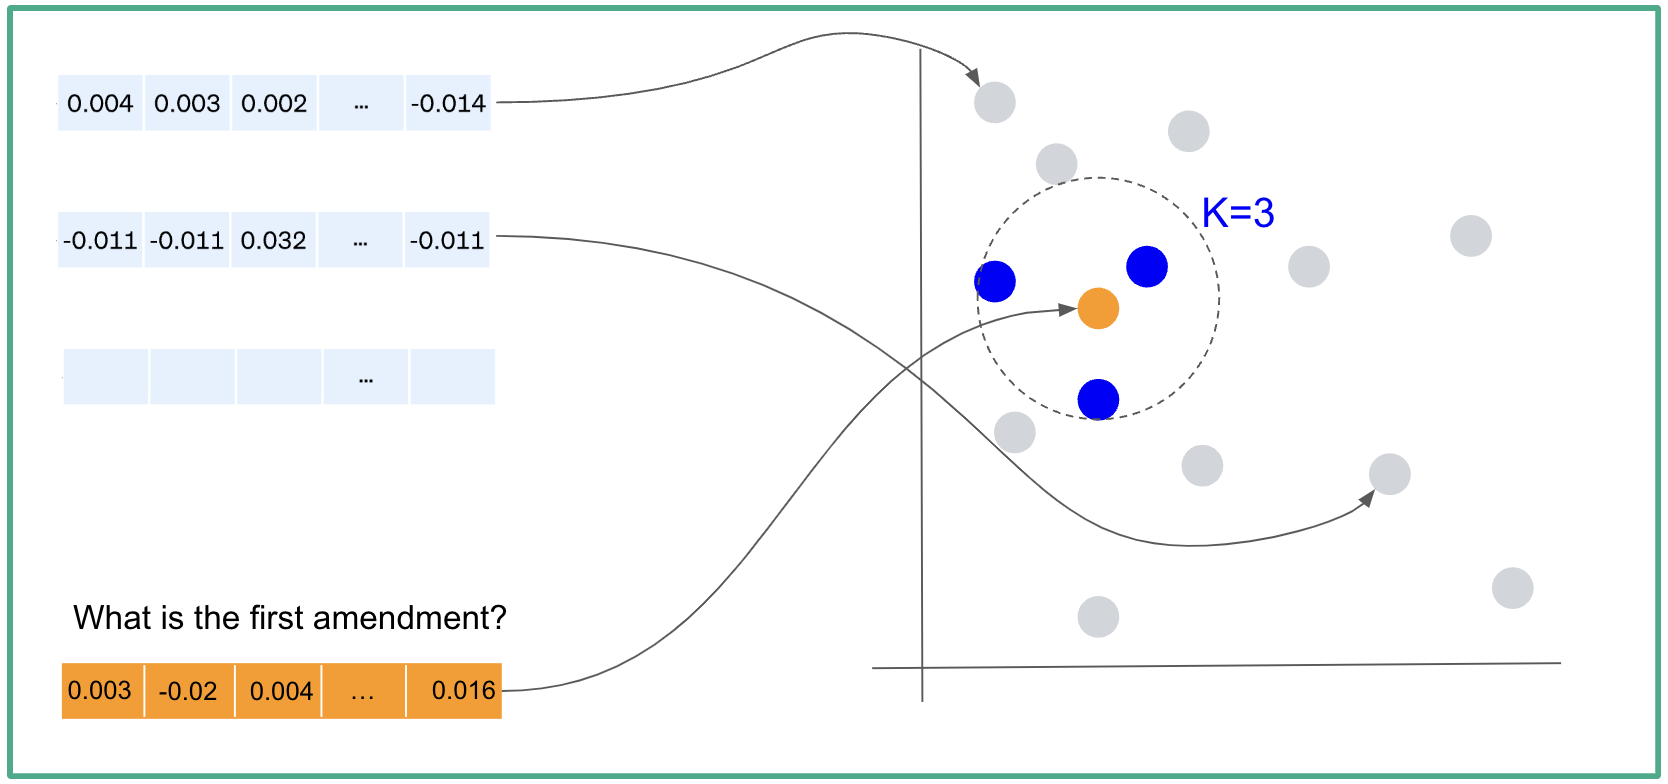

In [ ]:
retriever = vector_store.as_retriever()
query = "What did the president say about Justice Breyer?"
docs = retriever.get_relevant_documents(query)

In [ ]:
results_with_scores = vector_store.similarity_search_with_score(query)
for doc, score in results_with_scores:
    print(f"Metadata: {doc.metadata}, Score: {score}")

It is an L2 distance so the lower the score the better!

In [ ]:
def show_docs(docs):
  print(f"To answer the question, the following {len(docs)} documents will be used.\n")
  for doc in docs:
    print_chunk(doc)
    print("\n")

show_docs(docs)

## Chatbot in action!

Now it is time to define our Q&A chatbot that, based on the question, will retrieve the most relevant chunks and provides an answer. To define it we can handily use LangChain chain "load_qa_chain".

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain

In [ ]:
chain = load_qa_chain(llm=ChatOpenAI(temperature=0, model=MODEL_NAME),
                      chain_type="stuff"
                      )
query = "What did the president say about Justice Breyer?"
docs = retriever.get_relevant_documents(query)
chain.run(input_documents=docs, question=query)

Let's see what is happenning under the hood.

In [ ]:
chain.dict()['llm_chain']['prompt']

The prompt is making use of two input variables:

- `context`: this variable is replaced by the most relevant pieces of documents fetched from the vector store to answer the question

- `question`: the question provided by the user

You can also have more details by adding `verbose=True` to the load_qa chain arguments.

## Prompt customization

Now that the main logic of what is happening is more clear, we can try to customize the chain and provide our own instructions in the template. We should keep the input variables `context` and `question` but we can add our own variables too.

In [ ]:
from langchain.prompts import PromptTemplate

In [ ]:
prompt_template = """
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Answer in {language}:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question", "language"]
)
chain = load_qa_chain(llm=ChatOpenAI(temperature=0, model=MODEL_NAME),
                      chain_type="stuff",
                      prompt=PROMPT)

In [ ]:
query = "What did the president say about Justice Breyer"
docs = retriever.get_relevant_documents(query)
final_chain = chain({
    "input_documents": docs,
    "question": query,
    "language": "French"
    })
answer = final_chain['output_text']
answer

In [ ]:
query = "What did the president say about Justice Breyer"
docs = retriever.get_relevant_documents(query)
final_chain = chain({
    "input_documents": docs,
    "question": query,
    "language": "Italian"
    })
answer = final_chain['output_text']
answer

# 2: INTRODUCING MEMORY FOR A CONVERSATIONAL CHATBOT

A step further in the improvement of our chatbot would be to add a memory element to it so that can really feel like having a conversation with a virtual assistant rather than a simple Q&A assistant.

To do that we are going to use a different type of chain `RetrievalQA` that makes use of memory to keep track of conversations in the past.

In [ ]:
from langchain.chains import RetrievalQA
from langchain.memory import ConversationBufferMemory

In [ ]:
memory = ConversationBufferMemory(memory_key="history", input_key="question")

template = """
Use the following context (delimited by <ctx></ctx>) and the chat history (delimited by <hs></hs>) to answer the question:
------
<ctx>
{context}
</ctx>
------
<hs>
{history}
</hs>
------
{question}
Answer:
"""
prompt = PromptTemplate(
    input_variables=["history", "context", "question"],
    template=template,
)

In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(temperature=0, model_name=MODEL_NAME),
    chain_type='stuff',
    retriever=retriever,
    chain_type_kwargs={
        "prompt": prompt,
        "memory": memory,
    }
)

In [ ]:
qa.run({"query": "What did the president say about Justice Breyer?"})

In [ ]:
qa.run({"query": "Translate the first answer in French"})

# 3: INTEGRATE LLMS WITH YOUTUBE VIDEOS

The approach we have seen so far can be applied to a multitude of document types. The only step we need to take care of is the first one where we need to transform the raw source into a `Document` page. All the other steps will be the same!

We can, for example, use LLMs to ask questions about Youtube videos with a transcript. All we need is a specific document loader for this use case.

We can use `RetrievalQAWithSourcesChain` to retrieve the sources that were used by the LLM in order to generate the answer.

In [ ]:
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.document_loaders import YoutubeLoader


loader = YoutubeLoader.from_youtube_url(
    'https://www.youtube.com/watch?v=aywZrzNaKjs', add_video_info=True
)

youtube_transcripts = loader.load()

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents_chunks = text_splitter.split_documents(youtube_transcripts)
for idx, doc_chunk in enumerate(documents_chunks):
    doc_chunk.metadata['source'] = "https://www.youtube.com/watch?v=" + doc_chunk.metadata['source']


embeddings = OpenAIEmbeddings()
youtube_vector_store = FAISS.from_documents(documents_chunks, embeddings)


qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=ChatOpenAI(temperature=0, model_name=MODEL_NAME),
    retriever=youtube_vector_store.as_retriever()
)

In [ ]:
user_input = "What is the video about?"
result = qa_chain({"question": user_input})
result

In [ ]:
user_input = "What are the advantages of using LangChain?"
result = qa_chain({"question": user_input})
result

# EXERCISE: DATAROOTS WEBSITE


Now it is your turn to put into practice what we have learned so far! 🦾

Create an LLM application that can be used to ask questions about Dataroots website!

For example, a user may ask "What is Dataroots' DNA?" (https://dataroots.io/our-dna). We should give them a valide answer as a response.

You can provide multiple urls if you want to. <br>
Use a custom template, a vector store and LangChain objects to build up your application, have fun!😀